## Preamble 

In [1]:
import sys
sys.path.extend(["../../src/core", "../../src/utils"])
from draw import Draw
from io_manager import Load
from analyse import Analyse
from pyutils.pyplot import Plot
from pyutils.pyselect import Select
from pyutils.pyvector import Vector
from pyutils.pyprint import Print

import awkward as ak
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

## Load data

In [2]:
ana_label = "dev_CRY_mix2BB_onspill-LH_aw_noCRV"
data = Load(in_path = f"../../output/results/{ana_label}").load_pkl() 

[Load] ✅ Initialised with out_path=../../output/results/dev_CRY_mix2BB_onspill-LH_aw_noCRV
[Load] ✅ Successfully loaded results from ../../output/results/dev_CRY_mix2BB_onspill-LH_aw_noCRV/results.pkl


In [3]:
printer = Print()
# printer.print_n_events(data["events"])

[pyprint] ⭐️ Initialised Print with verbose = False and precision = 1


In [4]:
# test = data["events"]

In [5]:
# selector = Select()
# is_electron = selector.is_electron(data["events"]["trk"])

# test["trk"] = test["trk"][is_electron]
# test["trkfit"] = test["trkfit"][is_electron]

In [6]:
# # test["trk"] = ak.flatttest["trk"][is_electron]
# test["trkfit"] = ak.flatten(test["trkfit"], axis=-1)

In [7]:
# at_trk_front = selector.select_surface(test["trkfit"], "TT_Front")
# test["trkfit"] = test["trkfit"][at_trk_front]

In [16]:
def get_trk_crv_dt(trkfit, crv):
    """Helper to get trk/crv time difference (dT).

    Calculates the time difference between every track segment in trkfit and
    every CRV coincidence in crv for the same event.

    Args:
        trkfit (ak.Array): Contains track fit information per segment. 
        crv (ak.Array): Contains CRV coincidence information.

    Returns:
        ak.Array: Time difference dT (track segment time - CRV coincidence time).
                  Shape: [event, track, segment, coincidence]
    """
    # Find dT
    # Extract track segment times. Shape is [E, T, S] (Event, Track, Segment).
    trk_times = trkfit["trksegs"]["time"] 
    # Extract CRV coincidence times. Shape is [E, C] (Event, Coincidence).
    coinc_times = crv["crvcoincs.time"]  

    # Broadcast CRV times to match track structure so we can element-wise subtract.

    # Shape transform: [E, C] -> [E, 1, 1, C].
    # The '1' dimensions will be automatically expanded to match the
    # T and S dimensions during subtraction.
    coinc_broadcast = coinc_times[:, None, None, :] 
    
    # Broadcast track times to match the CRV structure.
    # Shape transform: [E, T, S] -> [E, T, S, 1].
    # The final '1' dimension will be broadcast to match the C dimension.
    trk_broadcast = trk_times[:, :, :, None] 
    
    # coinc_broadcast shape is [E, 1, 1, C]
    # trk_broadcast shape is [E, T, S, 1]
    
    # The subtraction now yields the desired shape [E, T, S, C], 
    # containing dT for every possible track-segment/CRV-coincidence pairing.

    # Return time differences
    return (trk_broadcast - coinc_broadcast)

# def _append_array(events, arr, name):
#     """Helper to append arrays/masks to dev field 
#     This is useful for debugging and development
#     Must be trk or trkfit level
#     """
#     if "dev" not in ak.fields(events):
#         # Initialise masks field with first mask
#         # events["dev"] = ak.zip({name: arr})
#         events = ak.with_field(events, ak.zip({name: arr}), "dev")
#     else: 
#         # Add to existing arrays
#         # Add new field to existing 'dev' record
#         new_dev_arr = ak.with_field(events["dev"], arr, name)
#         events = ak.with_field(events, new_dev_arr, "dev")

#     return events

# def _append_array(events, arr, name):
#     """Helper to append arrays/masks to dev field 
#     This is useful for debugging and development
#     Can handle any level (event, track, or trkfit level)
#     """
#     if "dev" not in ak.fields(events):
#         # Initialize dev field with first array
#         events = ak.with_field(events, {name: arr}, "dev")
#     else: 
#         # Add new field to existing 'dev' record
#         # Use dictionary update to avoid broadcasting
#         dev_dict = {field: events["dev"][field] for field in ak.fields(events["dev"])}
#         dev_dict[name] = arr
#         events = ak.with_field(events, dev_dict, "dev")

#     return events

# def _append_array(events, arr, name):
#     """Helper to append arrays/masks to dev field 
#     This is useful for debugging and development
#     Can handle any level (event, track, or trkfit level)
#     """
#     if "dev" not in ak.fields(events):
#         # Initialize dev field with first array
#         events = ak.with_field(events, {name: arr}, "dev")
#     else: 
#         # Add new field to existing 'dev' record directly
#         new_dev = ak.with_field(events.dev, arr, name)
#         events = ak.with_field(events, new_dev, "dev")

#     return events

def _append_array(events, arr, name):
    """Helper to append arrays/masks to dev field 
    This is useful for debugging and development
    Appended arrays must be compatible with trk and trkfit
    """
    if "dev" not in ak.fields(events):
        # Initialize dev field - structure will be determined by first array added
        events = ak.with_field(events, ak.zip({name: arr}, depth_limit=1), "dev")
    else: 
        # Add new field to existing 'dev' record
        new_dev = ak.with_field(events.dev, arr, name)
        events = ak.with_field(events, new_dev, "dev")

    return events

    
events = data["events"]

selector = Select(verbosity=0)
at_trk_mid = selector.select_surface(events["trkfit"], surface_name="TT_Mid")


# # Calculate time differences: [E, T, S, C] (Event, Track, Segment, Coincidence)
# dT = get_trk_crv_dt(events["trkfit"][at_trk_mid], events["crv"])

# # Time window cut - still at [E, T, S, C]
# veto_condition = (
#     (dT > -25)
#     & (dT < 150)
# )
# veto_condition = ak.fill_none(veto_condition, False)

# # Calculate vetoed at event level BEFORE flattening
# # A track is vetoed if *any* coincidence lies within the window
# # Reduce over coincidence, segment, and track axes to get [E]
# vetoed = ak.any(veto_condition, axis=-1)  # [E, T, S]
# vetoed = ak.any(vetoed, axis=-1)          # [E, T]
# # vetoed = ak.any(vetoed, axis=-1)          # [E]

# unvetoed = ~vetoed

# # NOW flatten dT for storage/analysis
# dT = ak.flatten(ak.flatten(dT, axis=3), axis=2)  # [E, C]

# # Store results
# events = _append_array(events, veto_condition, "veto_condition")  # This will be flattened too
# events = _append_array(events, dT, "dT") 
# events = _append_array(events, vetoed, "vetoed")      # [E] - scalar per event
# events = _append_array(events, unvetoed, "unvetoed")  # [E] - scalar per event

# # dT investigations 
# dT_vetoed = ak.mask(dT, veto_condition)
# dT_unvetoed = ak.mask(dT, ~veto_condition) 

# events = _append_array(events, dT_vetoed, "dT_vetoed") 
# events = _append_array(events, dT_unvetoed, "dT_unvetoed")


# Calculate time differences: [E, T, S, C] (Event, Track, Segment, Coincidence)
dT = get_trk_crv_dt(events["trkfit"][at_trk_mid], events["crv"])
# Fill in None with -inf, for cases where we have no coinc 
# dT = ak.fill_none(dT, -np.inf)
# Flatten to over coindicences (3) and segements (2) to track level
dT = ak.flatten(ak.flatten(dT, axis=3), axis=2) # [E, T]

# Fill in None for cases where we have no coinc 
# dT = ak.fill_none(dT, -9999)


# Time window cut 
veto_condition = (
    (dT > -25)
    & (dT < 150)
)

# event level veto 
vetoed = ak.any(veto_condition, axis=-1) # [:, None]
unvetoed = ~vetoed # invert
# for event to pass the veto, matches must be true? 
events = _append_array(events, dT, "dT") 
events = _append_array(events, veto_window, "veto_condition")
events = _append_array(events, vetoed, "vetoed") 
events = _append_array(events, unvetoed, "unvetoed") 

# # Fill None values for robustness
# # veto_window = ak.fill_none(veto_window, False)

# # A track is vetoed if *any* coincidence lies within the window
# # THIS SHOULD BE EVENT LEVEL, BROADCAST TO TRACK LEVEL
# vetoed = ak.any(veto_condition, axis=-1)
# # vetoed = vetoed[:, None]
# unvetoed = ~vetoed


# # Store 

# events = _append_array(events, vetoed, "vetoed")
# events = _append_array(events, unvetoed, "unvetoed")
# # _append_array(events, dT, "dT") 

# # # dT investigations 

dT_vetoed = ak.mask(dT, veto_condition)
dT_unvetoed = ak.mask(dT, ~veto_condition) 

# # Leading dT in/out of the veto window

# # RegularArray of size 16869 with RegularArray of size 16981
events = _append_array(events, dT_vetoed, "dT_vetoed") 
events = _append_array(events, dT_unvetoed, "dT_unvetoed") 


leading_dT_vetoed = dT_vetoed[ak.argmin(abs(dT_vetoed), axis=-1, keepdims=True)]
leading_dT_unvetoed = dT_unvetoed[ak.argmin(abs(dT_unvetoed), axis=-1, keepdims=True)]


# events = _append_array(events, leading_dT_vetoed, "leading_dT_vetoed") 
# events = _append_array(events, leading_dT_unvetoed, "leading_dT_unvetoed") 

In [17]:
printer.print_n_events(events, 10)

[pyprint] ⭐️ Printing 10 event(s)...

-------------------------------------------------------------------------------------
evt.run: 1202
evt.subrun: 37467
evt.event: 188137
crv.crvcoincs.time: [1.5e+03, 728]
crv.crvcoincs.nHits: [16, 10]
crv.crvcoincs.pos.fCoordinates.fZ: [-6.06e+03, -9.96e+03]
at_trk_front: [[False, False, False, False, False, ..., False, False, False, False], ...]
has_trk_front: [True, True, True, True]
is_reco_electron: [True, False, False, False]
one_reco_electron: [True, True, True, True]
one_reco_electron_per_event: True
is_downstream: [True, False, True, False]
is_truth_electron: [True, True, True, True]
good_trkqual: [True, True, True, True]
within_t0: [True, True, True, True]
within_t0err: [True, True, True, True]
has_hits: [True, True, True, True]
within_d0: [True, True, True, True]
pitch_angle: [[0.683, 0.479, 0.479, -0.387, -0.387, ..., -0.571, -0.387, 0.479, 0.479], ...]
within_pitch_angle_lo: [True, False, True, False]
within_pitch_angle_hi: [True, True,

In [148]:
test = ak.Array(
    {
        "a" : [[False, True], [True, True], [False, False], [True, False, False]]
    }
)

test["b"] = ak.any(test["a"], axis=-1)

test = _append_array(test, test["b"], "c")
printer.print_n_events(test, len(test))

[pyprint] ⭐️ Printing 4 event(s)...

-------------------------------------------------------------------------------------
a: [False, True]
b: True
dev.c: True
-------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------
a: [True, True]
b: True
dev.c: True
-------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------
a: [False, False]
b: False
dev.c: False
-------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------
a: [True, False, False]
b: True
dev.c: True
-------------------------------------------------------------------------------------



## Prepare data

In [20]:
##### dT #####

# Select
leading_dT = events["leading_dT"][events["select"]]
# Flatten to track level 
leading_dT_flat = ak.flatten(ak.flatten(leading_dT, axis=-1), axis=-1)
# [E, T, S, C]
# Store
events["leading_dT_flat"] = leading_dT_flat
# Valid mask (used to match momenta, for cases where we have no coincidence)
events["valid_leading_dT_flat"]  = ~ak.is_none(events["leading_dT_flat"] , axis=-1)

# ##### Momentum #####

# Get momentum magnitude at tracker front
vector = Vector(verbosity=0)
selector = Select(verbosity=0)
mom_mag = vector.get_mag(events["trkfit"]["trksegs"], "mom")
at_trk_front = selector.select_surface(events["trkfit"], surface_name="TT_Front")
mom_mag_at_trk_front = mom_mag[at_trk_front] 
# Flatten to track level 
mom_mag_at_trk_front = ak.flatten(mom_mag_at_trk_front, axis=-1)
# Store
events["mom_mag_at_trk_front"] = mom_mag_at_trk_front

# #### Veto ######

# split by all and unvetoed 
events = events 
events["unvetoed"] = ak.any(events["unvetoed_raw"] & events["select"], axis=-1)
unvetoed_events = events[events["unvetoed"]]

In [36]:
leading_dT_flat_2 = ak.flatten(leading_dT, axis=-1)
print(leading_dT_flat)
print(leading_dT_flat_2)

[[44.4], [96.3], [47.3], [46], [96.7], ..., [32], [66.5], [55], [56.8], [9.42]]
[[[44.4]], [[96.3]], [[47.3]], [[46]], ..., [[55]], [[56.8]], [[9.42]]]


In [43]:
leading_dT_flat_2 = ak.flatten(ak.flatten(leading_dT, axis=3), axis=2)
print(leading_dT_flat)
print(leading_dT_flat_2)

[[44.4], [96.3], [47.3], [46], [96.7], ..., [32], [66.5], [55], [56.8], [9.42]]
[[44.4], [96.3], [47.3], [46], [96.7], ..., [32], [66.5], [55], [56.8], [9.42]]


In [47]:
# leading_dT_flat_2 = ak.flatten(leading_dT, axis=(2,3)) 
# print(leading_dT_flat)
# print(leading_dT_flat_2)

dT = events["dT"][events["select"]]
print(dT)

[[[[44.4, 820]]], [[[249, 96.3]]], ..., [[[56.8]]], [[[9.42, 31.1]]]]


In [71]:
# ##### dT #####

# # Select 
# leading_dT = events["leading_dT"][events["select"]]
# leading_dT_unvetoed = events["leading_dT"][events["select"] & events["unvetoed_raw"]]
# # Flatten to track level 
# leading_dT = ak.flatten(ak.flatten(leading_dT, axis=-1), axis=-1)
# leading_dT_unvetoed = ak.flatten(ak.flatten(leading_dT_unvetoed, axis=-1), axis=-1)
# # Shapes
# print("leading_dT", leading_dT.type)
# print("leading_dT_unvetoed", leading_dT_unvetoed.type)

# # Valid masks (used to match momenta) 
# valid_leading_dT = ~ak.is_none(leading_dT, axis=-1)
# valid_leading_dT_unvetoed = ~ak.is_none(leading_dT_unvetoed, axis=-1)

# ##### Momentum #####

# # Get momentum magnitude at tracker front
# vector = Vector(verbosity=0)
# selector = Select(verbosity=0)
# mom_mag = vector.get_mag(events["trkfit"]["trksegs"], "mom")
# at_trk_front = selector.select_surface(events["trkfit"], surface_name="TT_Front")
# mom_mag_at_trk_front = mom_mag[at_trk_front] 
# # Flatten to track level 
# mom_mag_at_trk_front = ak.flatten(mom_mag_at_trk_front, axis=-1)

# print("mom_mag_at_trk_front", mom_mag_at_trk_front.type) 

## Plot 

In [21]:
plotter = Plot()
out_path = Path("../../output/images/comp/dT")
out_path.mkdir(parents=True, exist_ok=True)

[pyplot] ⭐️ Initialised Plot with mu2e.mplstyle and verbosity = 1


### Main dT

[pyplot] ✅ Wrote:
	../../output/images/comp/dT/h1_dT_leading_all.png


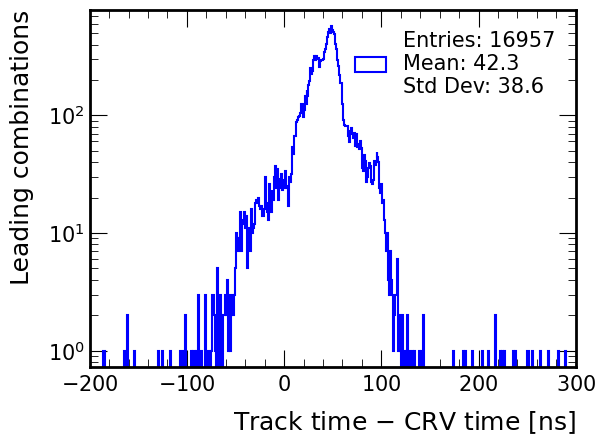

In [22]:
plotter.plot_1D( 
    ak.flatten(events["leading_dT_flat"], axis=None),
    nbins=500,
    xmin=-200, 
    xmax=300,
    xlabel=r"Track time $-$ CRV time [ns]",
    ylabel=r"Leading combinations",
    stat_box=True,
    log_y=True,
    show=True,
    col="blue",
    out_path=f"{out_path}/h1_dT_leading_all.png"
)

I think this is correct. Now need to mask according to momentum. You should only see three events in the veto window, right? 

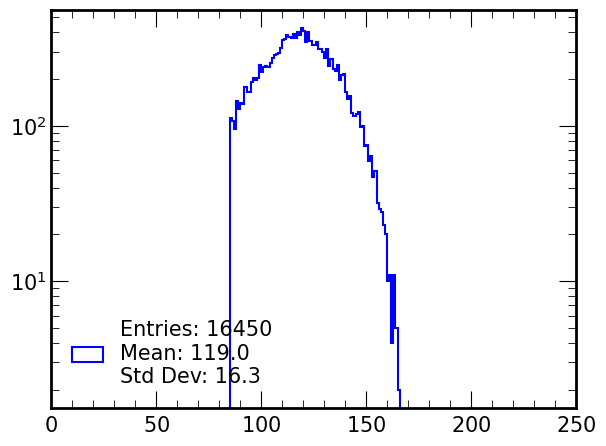

In [24]:
plotter.plot_1D( 
    ak.flatten(events["mom_mag_at_trk_front"][(events["mom_mag_at_trk_front"] > 85)], axis=None),
    nbins=250,
    xmin=0, 
    xmax=250,
    # xlabel=r"Track time $-$ CRV time [ns]",
    # ylabel=r"Leading combinations",
    stat_box=True,
    log_y=True,
    show=True,
    col="blue",
    # out_path=f"{out_path}/h1_dT_leading_all.png"
)

[pyplot] ✅ Wrote:
	../../output/images/comp/dT/h1_dT_leading_all.png


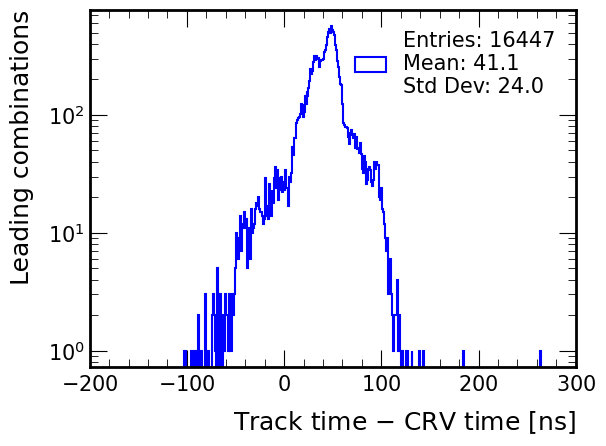

In [26]:
plotter.plot_1D( 
    ak.flatten(events["leading_dT_flat"][(events["mom_mag_at_trk_front"] > 85)], axis=None),
    nbins=500,
    xmin=-200, 
    xmax=300,
    xlabel=r"Track time $-$ CRV time [ns]",
    ylabel=r"Leading combinations",
    stat_box=True,
    log_y=True,
    show=True,
    col="blue",
    out_path=f"{out_path}/h1_dT_leading_all.png"
)

How does this work?

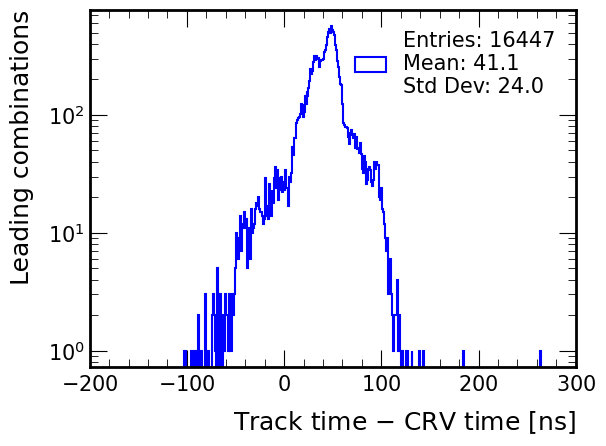

In [29]:
test = events[ak.all(events["mom_mag_at_trk_front"] > 85, axis=-1)]
plotter.plot_1D( 
    ak.flatten(test["leading_dT_flat"], axis=None),
    nbins=500,
    xmin=-200, 
    xmax=300,
    xlabel=r"Track time $-$ CRV time [ns]",
    ylabel=r"Leading combinations",
    stat_box=True,
    log_y=True,
    show=True,
    col="blue",
)

In [30]:
printer.print_n_events(test)

[pyprint] ⭐️ Printing 1 event(s)...

-------------------------------------------------------------------------------------
evt.run: 1202
evt.subrun: 37467
evt.event: 188137
crv.crvcoincs.time: [1.5e+03, 728]
crv.crvcoincs.nHits: [16, 10]
crv.crvcoincs.pos.fCoordinates.fZ: [-6.06e+03, -9.96e+03]
at_trk_front: [[False, False, False, False, False, ..., False, False, False, False], ...]
has_trk_front: [True, True, True, True]
is_reco_electron: [True, False, False, False]
one_reco_electron: [True, True, True, True]
one_reco_electron_per_event: True
is_downstream: [True, False, True, False]
is_truth_electron: [True, True, True, True]
good_trkqual: [True, True, True, True]
within_t0: [True, True, True, True]
within_t0err: [True, True, True, True]
has_hits: [True, True, True, True]
within_d0: [True, True, True, True]
pitch_angle: [[0.683, 0.479, 0.479, -0.387, -0.387, ..., -0.571, -0.387, 0.479, 0.479], ...]
within_pitch_angle_lo: [True, False, True, False]
within_pitch_angle_hi: [True, True, 

[pyplot] ✅ Wrote:
	../../output/images/comp/dT/h1_dT_leading_valid.png


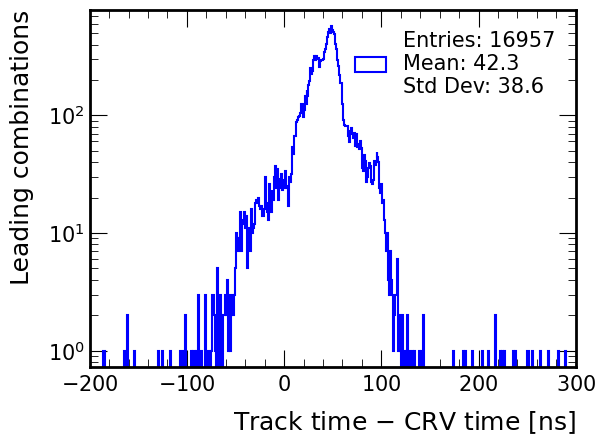

In [104]:
plotter.plot_1D( 
    ak.flatten(events["leading_dT_flat"][events["valid_leading_dT_flat"]], axis=None),
    nbins=500,
    xmin=-200, 
    xmax=300,
    xlabel=r"Track time $-$ CRV time [ns]",
    ylabel=r"Leading combinations",
    stat_box=True,
    log_y=True,
    show=True,
    col="blue",
    out_path=f"{out_path}/h1_dT_leading_valid.png"
)

In [108]:
test_leading_dT = events["leading_dT_flat"][((events["valid_leading_dT_flat"]) & (events["mom_mag_at_trk_front"] < 85))]

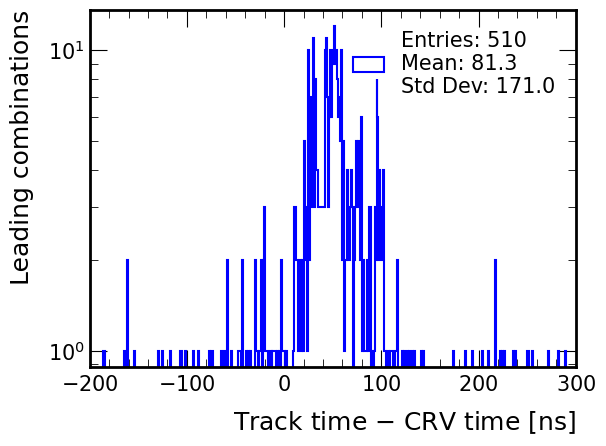

In [109]:
plotter.plot_1D( 
    ak.flatten(test_leading_dT, axis=None),
    nbins=500,
    xmin=-200, 
    xmax=300,
    xlabel=r"Track time $-$ CRV time [ns]",
    ylabel=r"Leading combinations",
    stat_box=True,
    log_y=True,
    show=True,
    col="blue",
    # out_path=f"{out_path}/h1_dT_leading_valid.png"
)

[pyplot] ✅ Wrote:
	../../output/images/comp/dT/h1_dT_leading_all.png


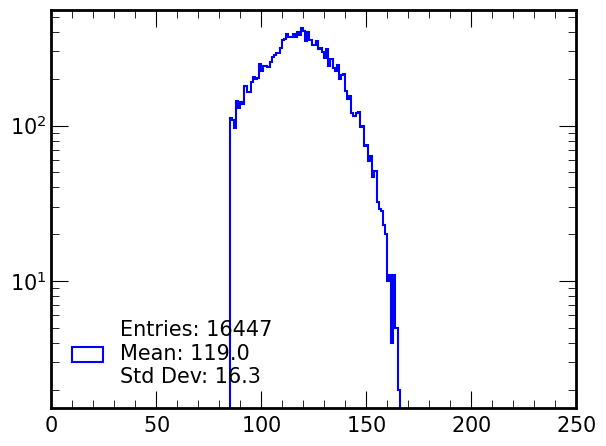

In [102]:
plotter.plot_1D( 
    ak.flatten(events["mom_mag_at_trk_front"][events["valid_leading_dT_flat"] & (events["mom_mag_at_trk_front"] > 85)], axis=None),
    nbins=250,
    xmin=0, 
    xmax=250,
    # xlabel=r"Track time $-$ CRV time [ns]",
    # ylabel=r"Leading combinations",
    stat_box=True,
    log_y=True,
    show=True,
    col="blue",
    out_path=f"{out_path}/h1_dT_leading_all.png"
)

## Unvetoed 

88 valid pairs 
112 total unvetoed events (sometimes we have no coincidence) 

	Wrote ../../output/images/comp/dT/h1_1x2_mom_and_dT.png


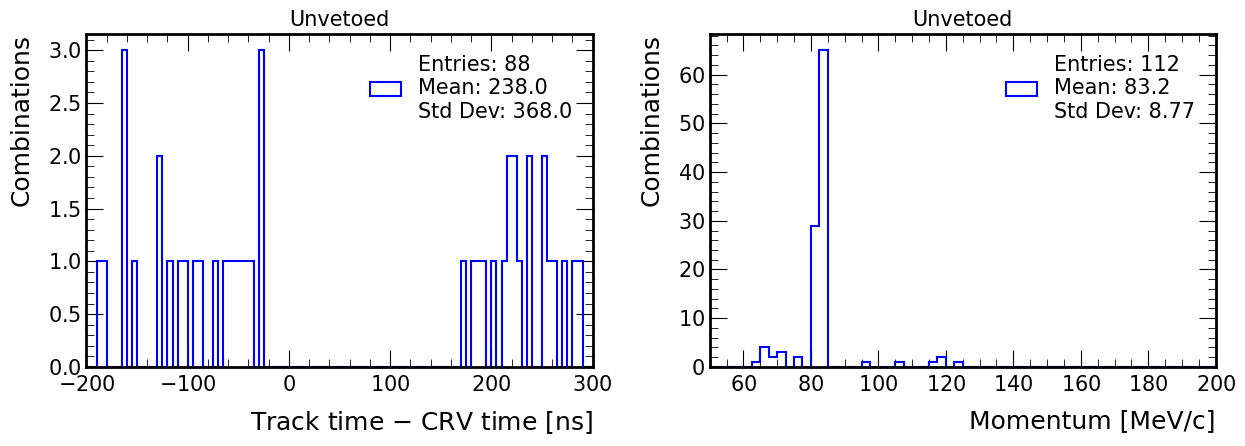

In [97]:
fig, ax = plt.subplots(1, 2, figsize=(2*6.4, 4.8))

plotter.plot_1D( 
    ak.flatten(unvetoed_events["leading_dT_flat"], axis=None),
    nbins=100,
    xmin=-200, 
    xmax=300,
    title=r"Unvetoed",
    xlabel=r"Track time $-$ CRV time [ns]",
    ylabel=r"Combinations",
    show=False,
    col="blue",
    ax=ax[0]
)

plotter.plot_1D( 
    # ak.flatten(unvetoed_events["mom_mag_at_trk_front"][unvetoed_events["valid_leading_dT_flat"]], axis=None),
    ak.flatten(unvetoed_events["mom_mag_at_trk_front"], axis=None),
    nbins=60,
    xmin=50, 
    xmax=200,
    col="blue",
    title=r"Unvetoed",
    xlabel=r"Momentum [MeV/c]",
    ylabel=r"Combinations",
    show=False,
    ax=ax[1]
)

plt.tight_layout()
out_file_name = f"{out_path}/h1_1x2_mom_and_dT.png"
plt.savefig(out_file_name, dpi=300)
print(f"\tWrote {out_file_name}")
plt.show()

# 2D comparison 

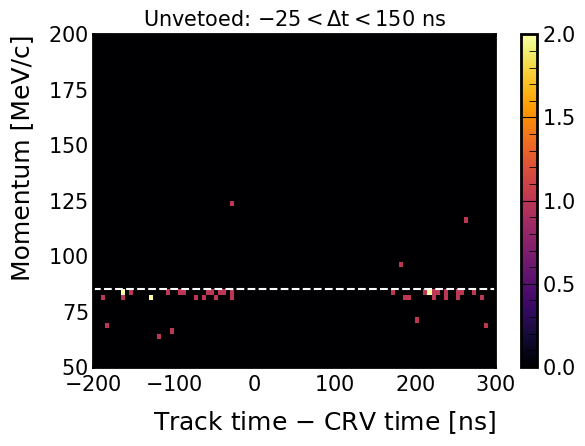

Wrote ../../output/images/comp/dT/h2_mom_vs_dt_unvetoed.png


In [84]:
fig, ax = plt.subplots()

plotter.plot_2D( 
    x=ak.flatten(unvetoed_events["leading_dT_flat"], axis=None),
    y=ak.flatten(unvetoed_events["mom_mag_at_trk_front"][unvetoed_events["valid_leading_dT_flat"]], axis=None),
    nbins_x=100,
    xmin=-200, 
    xmax=300,
    nbins_y=60,
    ymin=50, 
    ymax=200,
    show=False,
    ax=ax,
    title=r"Unvetoed: $-25 < \Delta t < 150$ ns",
    xlabel=r"Track time $-$ CRV time [ns]",
    ylabel=r"Momentum [MeV/c]",
)

plt.tight_layout()
ax.axhline(85, linestyle="--", color="white")

out_file_name = f"{out_path}/h2_mom_vs_dt_unvetoed.png"
plt.savefig(out_file_name, dpi=300)
plt.show()
print(f"Wrote {out_file_name}")

## CRV z-position? 

Need non-leading dT for this 

## Events above 85 

In [94]:
condition = (
    ak.all(unvetoed_events["mom_mag_at_trk_front"] > 85, axis=-1)
)
print(condition)

unvetoed_above_85 = unvetoed_events[condition] # ak.flatten(mom_mag_at_trk_front > 85, axis=-1)] # flatten to event level
print(len(unvetoed_above_85))

[False, False, False, False, False, ..., False, False, False, False, False]
6


In [95]:
printer.print_n_events(unvetoed_above_85, len(unvetoed_above_85))

[pyprint] ⭐️ Printing 6 event(s)...

-------------------------------------------------------------------------------------
evt.run: 1202
evt.subrun: 37501
evt.event: 415140
crv.crvcoincs.time: []
crv.crvcoincs.nHits: []
crv.crvcoincs.pos.fCoordinates.fZ: []
at_trk_front: [[False, False, False, False, False, ..., False, False, False, False], ...]
has_trk_front: [True, True, True, True, True]
is_reco_electron: [True, False, False, False, False]
one_reco_electron: [True, True, True, True, True]
one_reco_electron_per_event: True
is_downstream: [True, False, True, True, False]
is_truth_electron: [True, True, True, True, True]
good_trkqual: [True, False, True, False, False]
within_t0: [True, True, True, True, True]
within_t0err: [True, False, True, True, False]
has_hits: [True, True, True, False, False]
within_d0: [True, True, True, False, True]
pitch_angle: [[0.851, 0.683, 0.485, 0.484, -0.438, ..., -0.44, -0.437, 0.483, 0.486], ...]
within_pitch_angle_lo: [True, False, True, True, False]
w